<div>
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" width=100>
</div>

# Project 3: Web APIs & NLP

## Background

[Reddit](https:www.reddit.com) is a network of communities where people can dive into their interests, hobbies and passions. Subreddits are user-created channels where discussion on the topic of interest, hobby or passion are organized. From [Metrics For Reddit](https://frontpagemetrics.com/history), there are over 3.2 million subreddits as of December 2021, with hundreds of subreddits being created every day. 

1. Using [Pushshift's](https://github.com/pushshift/api) API, posts are collected from the two subreddits of [nosleep](https://www.reddit.com/r/nosleep/) and [paranormal](https://www.reddit.com/r/paranormal/).
2. NLP is then utilized in order to train a classifier on which subreddit a given post came from.

## Problem Statement

As there are many different subreddits on Reddit, and since interests, hobbies and passions can be similar, there are always various subreddits that are similar to each other. Without a doubt, anyone who is new to writing and posting to Reddit can be confused as to which subreddit to post to. In this project, the aim is to assist the new Reddit user in the decision of which subreddit to make the post in.

For the context of this project, the post is in the form of a scary experience, and the choices of the two of the subreddits are [nosleep](https://www.reddit.com/r/nosleep/) and [paranormal](https://www.reddit.com/r/paranormal/), two subreddits that cater to scary personal experiences and paranormal experiences, thoughts and theories.

## Progress so far

Using the [Pushshift's](https://github.com/pushshift/api) API, posts are collected from the two subreddits of [nosleep](https://www.reddit.com/r/nosleep/) and [paranormal](https://www.reddit.com/r/paranormal/), and then compiled into CSVs.

`At this point in time, `

## Part 3: Modelling and Analysis

### Imports (All imported libraries are added here)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

### Importing the Dataset

In [2]:
# Importing the preprocessed dataset
df = pd.read_csv('../datasets/data_model.csv')

In [3]:
# Checking the first 5 rows 
df.head()

,subreddit,text,text_stoptokens,text_lem,text_stem,text_stemlem
0,1,I created a new plant. It's gonna hurt a lot o...,"['created', 'new', 'plant', 'gonna', 'hurt', '...",created new plant gonna hurt lot people create...,creat new plant gonna hurt lot peopl creat new...,creat new plant gonna hurt lot peopl creat new...
1,1,The people I kill won't stay dead. I'm not wri...,"['people', 'kill', 'stay', 'dead', 'writing', ...",people kill stay dead writing sort confession ...,peopl kill stay dead write sort confess event ...,peopl kill stay dead write sort confess event ...
2,1,Don't got to the Magic Show at the Gypsy Carni...,"['got', 'magic', 'show', 'gypsy', 'carnival', ...",got magic show gypsy carnival final part 1 l p...,got magic show gypsi carniv final part 1 l par...,got magic show gypsi carniv final part 1 l par...
3,1,"""Intent: The Truth"" - Randonauting is not that...","['intent', 'truth', 'randonauting', 'fun', 'he...",intent truth randonauting fun hell ella exclai...,intent truth randonaut fun hell ella exclaim w...,intent truth randonaut fun hell ella exclaim w...
4,1,Accused in the Woods I have had the privilege ...,"['accused', 'woods', 'privilege', 'living', 'a...",accused wood privilege living america country ...,accus wood privileg live america countri one f...,accus wood privileg live america countri one f...


In [4]:
# Checking the shape of dataframe
df.shape

(1450, 6)

### Top Word Features

At this point in time, let's do a quick check on the top occurring words for the two datasets. We will be using `CountVectorizer` to do this.

In [5]:
# Instantiate a CountVectorizer with stop words
cvec_nosleep = CountVectorizer(stop_words='english')

# Fit the vectorizer on our corpus.
cvec_nosleep.fit(df[df['subreddit'] == 1]['text_stemlem'])

# Transform 
Z_nosleep = cvec_nosleep.transform(df[df['subreddit'] == 1]['text_stemlem'])

(625, 17298)

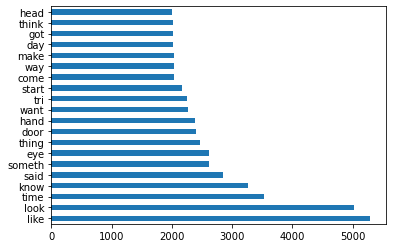

In [6]:
# Convert Z_nosleep into a DataFrame.
Z_nosleep_df = pd.DataFrame(Z_nosleep.todense(), 
                            columns=cvec_nosleep.get_feature_names_out())

# display shape of Z_nosleep_df
display(Z_nosleep_df.shape)

# plot top occuring words
Z_nosleep_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh');

In [7]:
# Instantiate a CountVectorizer with stop words
cvec_paranormal = CountVectorizer(stop_words='english')

# Fit the vectorizer on our corpus.
cvec_paranormal.fit(df[df['subreddit'] == 0]['text_stemlem'])

# Transform 
Z_paranormal = cvec_paranormal.transform(df[df['subreddit'] == 0]['text_stemlem'])

(825, 6900)

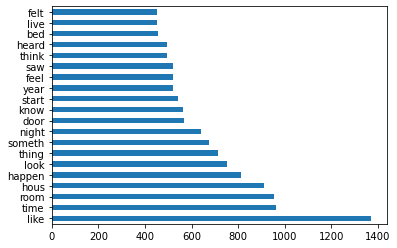

In [8]:
# Convert Z_paranormal into a DataFrame.
Z_paranormal_df = pd.DataFrame(Z_paranormal.todense(), 
                              columns=cvec_paranormal.get_feature_names_out())

# display shape of Z_nosleep_df
display(Z_paranormal_df.shape)

# plot top occuring words
Z_paranormal_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh');

### Modelling

For the modelling process, since we are attempting to train our model based solely on the text content of the subreddit post, the only feature (ie X variable) will be one of the above `text` columns. The four `text` columns are namely the `text` columns that have undergone text preprocessing of: None, Lemmentization, Stemming, or Lemmentization and Stemming.

In the modelling process, we will be using one of the two transformers `CountVectorizer` or `TFIDVectorizer`, and one of the following estimators: `MultinomialNB`, `LogisticRegression`, `KNeighborsClassifier`.

#### Set up the data for modelling

For now, the target variable is the `subreddit` column, and the feature column chosen will be the `text_stemlem` column. The value of 1 for `subreddit` is for `nosleep` and the value of 0 is for `paranormal`.

In [9]:
# determining the X and y variables
X = df['text_stemlem']
y = df['subreddit']

# shape of X and y variables
display(X.shape)
display(y.shape)

(1450,)

(1450,)

In [10]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

In [11]:
# baseline accuracy
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.568537
1    0.431463
Name: subreddit, dtype: float64
0    0.570248
1    0.429752
Name: subreddit, dtype: float64


|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- |

Taking the baseline model through the act of just declaring that every post is from the targetted subreddit, we have the above scores. This is just to act as a baseline to compare the results of the modelling.

### 1. Naive Bayes Model

#### 1.1 Naive Bayes Model with CountVectorizer

In [12]:
# Instantiate a Pipeline with CountVectorizer (Transformer) and MultinomialNB (Estimator)
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Hyperparameters for the above pipeline
pipe_nb_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)]    
}

In [13]:
# Instantiate GridSearchCV with pipeline of CountVectorizer (Transformer) and MultinomialNB (Estimator)
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, pipe_nb_cvec_params, cv = 5)

In [14]:
%%time
# Fit GridSearch to training data.
gs_nb_cvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_nb_cvec.best_params_

Wall time: 4min 16s


{'cvec__max_df': 0.7,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [15]:
# Score model on training set
print(round(gs_nb_cvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_nb_cvec.score(X_test, y_test), 4))

0.9457
0.9449


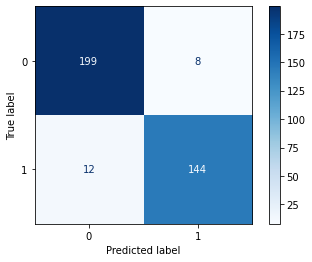

In [16]:
# Get predictions from model
pred_nb_cvec = gs_nb_cvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_nb_cvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb_cvec, cmap='Blues', values_format='d');

In [17]:
# Calculate the specificity
spec_nb_cvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_nb_cvec)

# Calculate the sensitivity
sens_nb_cvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_nb_cvec)

Specificity:  0.9614
Sensitivity:  0.9231


|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**CountVectorizer**| 0.9457 | 0.9449 | 199 | 8 | 12 | 144 | 0.9614 | 0.9231 |

From the above, we can see that the Naive Bayes Model with CountVectorizer has improved a lot on the baseline. But as this is the first model, we cannot make any decisions on whether this model is the best or not. At this point, there is little to no overfitting of the model, so this is a good model for now.

#### 1.2 Naive Bayes Model with TfidfVectorizer

In [18]:
# Instantiate a Pipeline with TfidfVectorizer (Transformer) and MultinomialNB (Estimator)
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Hyperparameters for the above pipeline
pipe_nb_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.7, .8, .9],
    'tvec__ngram_range': [(1,1), (1,2)]    
}

In [19]:
# Instantiate GridSearchCV with pipeline of TfidfVectorizer (Transformer) and MultinomialNB (Estimator)
gs_nb_tvec = GridSearchCV(pipe_nb_tvec, pipe_nb_tvec_params, cv = 5)

In [20]:
%%time
# Fit GridSearch to training data.
gs_nb_tvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_nb_tvec.best_params_

Wall time: 4min 18s


{'tvec__max_df': 0.7,
 'tvec__max_features': 4000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 1)}

In [21]:
# Score model on training set
print(round(gs_nb_tvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_nb_tvec.score(X_test, y_test), 4))

0.9512
0.9394


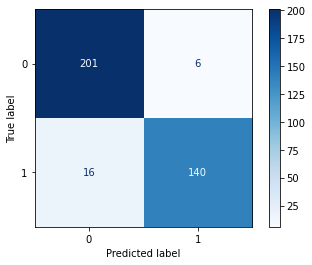

In [22]:
# Get predictions from model
pred_nb_tvec = gs_nb_tvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_nb_tvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb_tvec, cmap='Blues', values_format='d');

In [23]:
# Calculate the specificity
spec_nb_tvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_nb_tvec)

# Calculate the sensitivity
sens_nb_tvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_nb_tvec)

Specificity:  0.971
Sensitivity:  0.8974


|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**CountVectorizer**| 0.9457 | 0.9449 | 199 | 8 | 12 | 144 | 0.9614 | 0.9231 |
|**Naive Bayes**|**TfidfVectorizer**| 0.9512 | 0.9394 | 201 | 6 | 16 | 140 | 0.971 | 0.8974 |

From the start, the Naive Bayes Model with TfidfVectorizer shows signs of overfitting as the test score is slightly worse. As such, the accuracy of the model falls off a little. It should be noted that this model scores better in specificity, but worse off in sensitivity. Thus, this model with TfidfVectorizer does not seem to do better than the other model with CountVectorizer. 

### 2. Logistic Regression Model

#### 2.1 Logistic Regression Model with CountVectorizer

In [24]:
# Instantiate a Pipeline with CountVectorizer (Transformer) and LogisticRegression (Estimator)
pipe_logreg_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Hyperparameters for the above pipeline
pipe_logreg_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)]    
}

In [25]:
# Instantiate GridSearchCV with pipeline of CountVectorizer (Transformer) and LogisticRegression (Estimator)
gs_logreg_cvec = GridSearchCV(pipe_logreg_cvec, pipe_logreg_cvec_params, cv = 5)

In [26]:
%%time
# Fit GridSearch to training data.
gs_logreg_cvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_logreg_cvec.best_params_

Wall time: 4min 22s


{'cvec__max_df': 0.8,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [27]:
# Score model on training set
print(round(gs_logreg_cvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_logreg_cvec.score(X_test, y_test), 4))

0.9991
0.9559


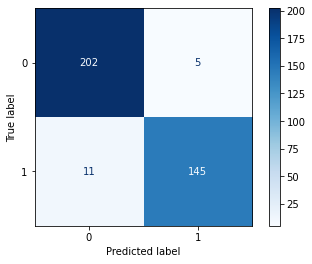

In [28]:
# Get predictions from model
pred_logreg_cvec = gs_logreg_cvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_logreg_cvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_logreg_cvec, cmap='Blues', values_format='d');

In [29]:
# Calculate the specificity
spec_logreg_cvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_logreg_cvec)

# Calculate the sensitivity
sens_logreg_cvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_logreg_cvec)

Specificity:  0.9758
Sensitivity:  0.9295


|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**CountVectorizer**| 0.9457 | 0.9449 | 199 | 8 | 12 | 144 | 0.9614 | 0.9231 |
|**Naive Bayes**|**TfidfVectorizer**| 0.9512 | 0.9394 | 201 | 6 | 16 | 140 | 0.971 | 0.8974 |
|**Logistics Regression**|**CountVectorizer**| 0.9991 | 0.9559 | 202 | 5 | 11 | 145 | 0.9758 | 0.9295 |

As before, this model is quite overfit to the training data. But it should be noted here that scores for accuracy, specificity and sensitivity is the best among the three models thus far. However, this model can be further improved by making it less overfit.

#### 2.2 Logistic Regression Model with TfidfVectorizer

In [30]:
# Instantiate a Pipeline with TfidfVectorizer (Transformer) and LogisticRegression (Estimator)
pipe_logreg_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Hyperparameters for the above pipeline
pipe_logreg_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.7, .8, .9],
    'tvec__ngram_range': [(1,1), (1,2)]    
}

In [31]:
# Instantiate GridSearchCV with pipeline of TfidfVectorizer (Transformer) and LogisticRegression (Estimator)
gs_logreg_tvec = GridSearchCV(pipe_logreg_tvec, pipe_logreg_tvec_params, cv = 5)

In [32]:
%%time
# Fit GridSearch to training data.
gs_logreg_tvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_logreg_tvec.best_params_

Wall time: 4min 13s


{'tvec__max_df': 0.7,
 'tvec__max_features': 2000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [33]:
# Score model on training set
print(round(gs_logreg_tvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_logreg_tvec.score(X_test, y_test), 4))

0.9687
0.9532


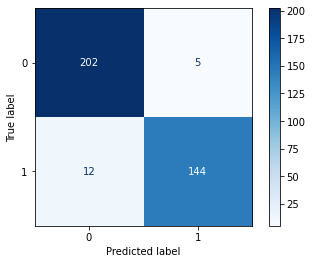

In [34]:
# Get predictions from model
pred_logreg_tvec = gs_logreg_tvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_logreg_tvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_logreg_tvec, cmap='Blues', values_format='d');

In [35]:
# Calculate the specificity
spec_logreg_tvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_logreg_tvec)

# Calculate the sensitivity
sens_logreg_tvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_logreg_tvec)

Specificity:  0.9758
Sensitivity:  0.9231


|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**CountVectorizer**| 0.9457 | 0.9449 | 199 | 8 | 12 | 144 | 0.9614 | 0.9231 |
|**Naive Bayes**|**TfidfVectorizer**| 0.9512 | 0.9394 | 201 | 6 | 16 | 140 | 0.971 | 0.8974 |
|**Logistics Regression**|**CountVectorizer**| 0.9991 | 0.9559 | 202 | 5 | 11 | 145 | 0.9758 | 0.9295 |
|**Logistics Regression**|**TfidfVectorizer**| 0.9687 | 0.9532 | 202 | 5 | 12 | 144 | 0.9758 | 0.9231 |

As before, this model is also slightly overfit to the training data. Other than that, it shows similar (though slightly worse) scoring when compared to the Logistics Regression Model with CountVectorizer. As such, in a way, this model may be a better model.

### 3. K Nearest Neighbors Model

#### 3.1 K Nearest Neighbors Model with CountVectorizer

In [36]:
# Instantiate a Pipeline with CountVectorizer (Transformer) and KNeighborsClassifier (Estimator)
pipe_knn_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters for the above pipeline
pipe_knn_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)]    
}

In [37]:
# Instantiate GridSearchCV with pipeline of CountVectorizer (Transformer) and KNeighborsClassifier (Estimator)
gs_knn_cvec = GridSearchCV(pipe_knn_cvec, pipe_knn_cvec_params, cv = 5)

In [38]:
%%time
# Fit GridSearch to training data.
gs_knn_cvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_knn_cvec.best_params_

Wall time: 4min 27s


{'cvec__max_df': 0.8,
 'cvec__max_features': 2000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2)}

In [39]:
# Score model on training set
print(round(gs_knn_cvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_knn_cvec.score(X_test, y_test), 4))

0.7948
0.7906


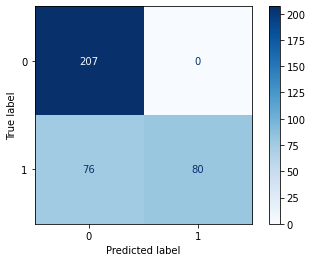

In [40]:
# Get predictions from model
pred_knn_cvec = gs_knn_cvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_knn_cvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_knn_cvec, cmap='Blues', values_format='d');

In [41]:
# Calculate the specificity
spec_knn_cvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_knn_cvec)

# Calculate the sensitivity
sens_knn_cvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_knn_cvec)

Specificity:  1.0
Sensitivity:  0.5128


|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**CountVectorizer**| 0.9457 | 0.9449 | 199 | 8 | 12 | 144 | 0.9614 | 0.9231 |
|**Naive Bayes**|**TfidfVectorizer**| 0.9512 | 0.9394 | 201 | 6 | 16 | 140 | 0.971 | 0.8974 |
|**Logistics Regression**|**CountVectorizer**| 0.9991 | 0.9559 | 202 | 5 | 11 | 145 | 0.9758 | 0.9295 |
|**Logistics Regression**|**TfidfVectorizer**| 0.9687 | 0.9532 | 202 | 5 | 12 | 144 | 0.9758 | 0.9231 |
|**KNeighborsClassifier**|**CountVectorizer**| 0.7948 | 0.7906 | 207 | 0 | 76 | 80 | 1.0 | 0.5128 |

For this model, the first thing to note is that the accuracy has drastically dropped when compared to the previous models. While the specificity is 1, the sensitivity is very low as this model is making a lot more posts as not belonging to the targetted subreddit.

#### 3.2 KNeighborsClassifier Model with TfidfVectorizer

In [42]:
# Instantiate a Pipeline with TfidfVectorizer (Transformer) and KNeighborsClassifier (Estimator)
pipe_knn_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters for the above pipeline
pipe_knn_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.7, .8, .9],
    'tvec__ngram_range': [(1,1), (1,2)]    
}

In [43]:
# Instantiate GridSearchCV with pipeline of TfidfVectorizer (Transformer) and KNeighborsClassifier (Estimator)
gs_knn_tvec = GridSearchCV(pipe_knn_tvec, pipe_knn_tvec_params, cv = 5)

In [44]:
%%time
# Fit GridSearch to training data.
gs_knn_tvec.fit(X_train, y_train)

# best parameters from the GridSearch
gs_knn_tvec.best_params_

Wall time: 4min 19s


{'tvec__max_df': 0.8,
 'tvec__max_features': 4000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1)}

In [45]:
# Score model on training set
print(round(gs_knn_tvec.score(X_train, y_train), 4))

# Score model on testing set
print(round(gs_knn_tvec.score(X_test, y_test), 4))

0.9108
0.865


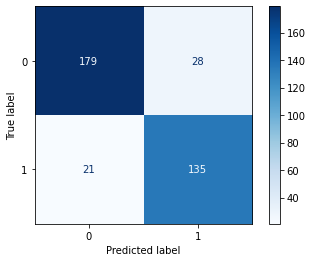

In [46]:
# Get predictions from model
pred_knn_tvec = gs_knn_tvec.predict(X_test)

# Save confusion matrix values of model
tn, fp, fn, tp = confusion_matrix(y_test, pred_knn_tvec).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_knn_tvec, cmap='Blues', values_format='d');

In [47]:
# Calculate the specificity
spec_knn_tvec = round(tn / (tn + fp), 4)
print('Specificity: ', spec_knn_tvec)

# Calculate the sensitivity
sens_knn_tvec = round(tp / (tp + fn), 4)
print('Sensitivity: ', sens_knn_tvec)

Specificity:  0.8647
Sensitivity:  0.8654


|Model|Transformer|Train Score|Test Score| TN | FP | FN | TP | Specificity | Sensitivity | 
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**Baseline**|**None**| 0.431463 | 0.429752 | -- | -- | -- | -- | -- | -- |
|**Naive Bayes**|**CountVectorizer**| 0.9457 | 0.9449 | 199 | 8 | 12 | 144 | 0.9614 | 0.9231 |
|**Naive Bayes**|**TfidfVectorizer**| 0.9512 | 0.9394 | 201 | 6 | 16 | 140 | 0.971 | 0.8974 |
|**Logistics Regression**|**CountVectorizer**| 0.9991 | 0.9559 | 202 | 5 | 11 | 145 | 0.9758 | 0.9295 |
|**Logistics Regression**|**TfidfVectorizer**| 0.9687 | 0.9532 | 202 | 5 | 12 | 144 | 0.9758 | 0.9231 |
|**KNeighborsClassifier**|**CountVectorizer**| 0.7948 | 0.7906 | 207 | 0 | 76 | 80 | 1.0 | 0.5128 |
|**KNeighborsClassifier**|**TfidfVectorizer**| 0.9108 | 0.865 | 179 | 28 | 21 | 135 | 0.8647 | 0.8654 |

In the case of this model, the first thing to note is that the accuracy has improved when compared to the previous KNeighborsClassifier model, though it suffers from overfitting. However, when compared to the other models with the same TfidfVectorizer transformer, this fares worse. As such, we will not be considering this model for the final modelling.

### 4. Final Model

### 5. Conclusion